In [76]:
import re
import os
import polars as pl
import matplotlib.pyplot as plt
from transformers import pipeline

# SciEval

In [77]:
# uncomment to download
# dataset = datasets.load_dataset("OpenDFM/SciEval")
# dataset.save_to_disk("./SciEval")

In [99]:
df_scieval = (
    pl.read_ipc_stream("SciEval/test/data-00000-of-00001.arrow")
    .filter(pl.col("category") == "physics")
    .with_columns(pl.col("answer").map_elements(lambda x: len(x), return_dtype=pl.Int32))
)

In [100]:
agg_cols = [c for c in df_scieval.columns if c != "question"]

df_scieval = df_scieval.group_by("question", maintain_order=True).agg(
    [pl.col(c).drop_nulls().first().alias(c) for c in agg_cols]
)

In [101]:
scieval_topics = df_scieval.group_by("topic").len().sort("len", descending=True)

In [104]:
scieval_topics.head(14)["topic"].to_list()

['Work and Energy',
 "Forces and Newton's Laws",
 'Electrical Energy and Current',
 'Momentum and Collisions',
 'Rotational Motion',
 'Heat',
 '2D Motion',
 '1D Motion',
 'Subatomic Physics',
 'Thermodynamics',
 'Circular Motion and Gravitation',
 'Fluid Mechanics',
 'Waves and Vibrations',
 'Circuits']

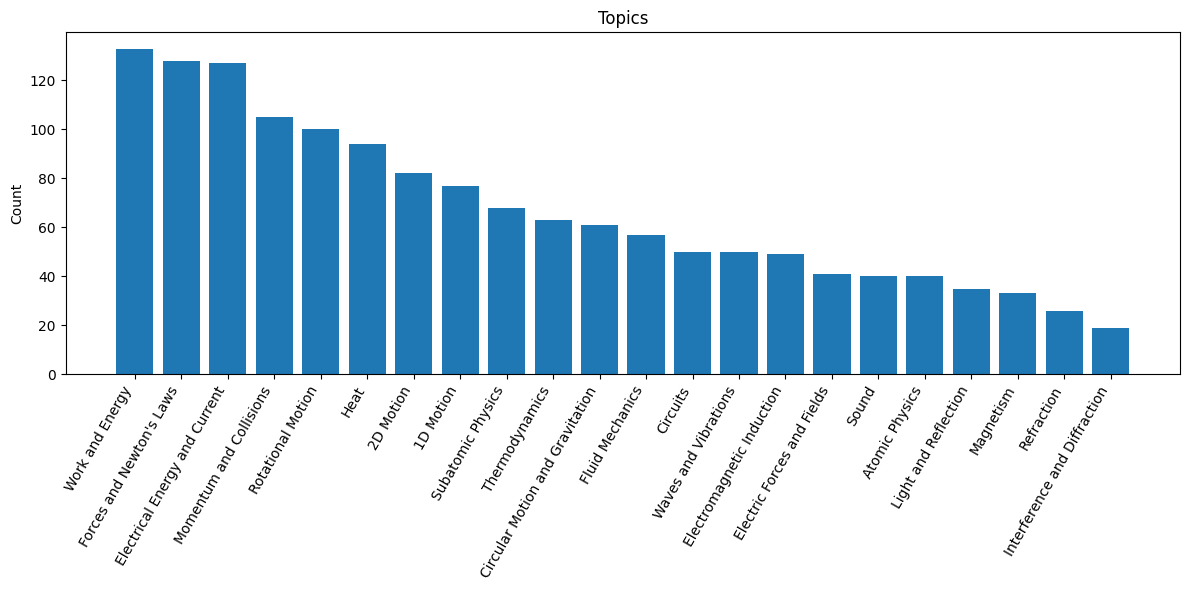

In [6]:
plt.figure(figsize=(12, 6))
plt.bar(scieval_topics["topic"], scieval_topics["len"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Count")
plt.title("Topics")
plt.tight_layout()
plt.savefig("figure.png")
plt.show()

In [7]:
abilities = df_scieval.group_by("ability").len().sort("len", descending=True)

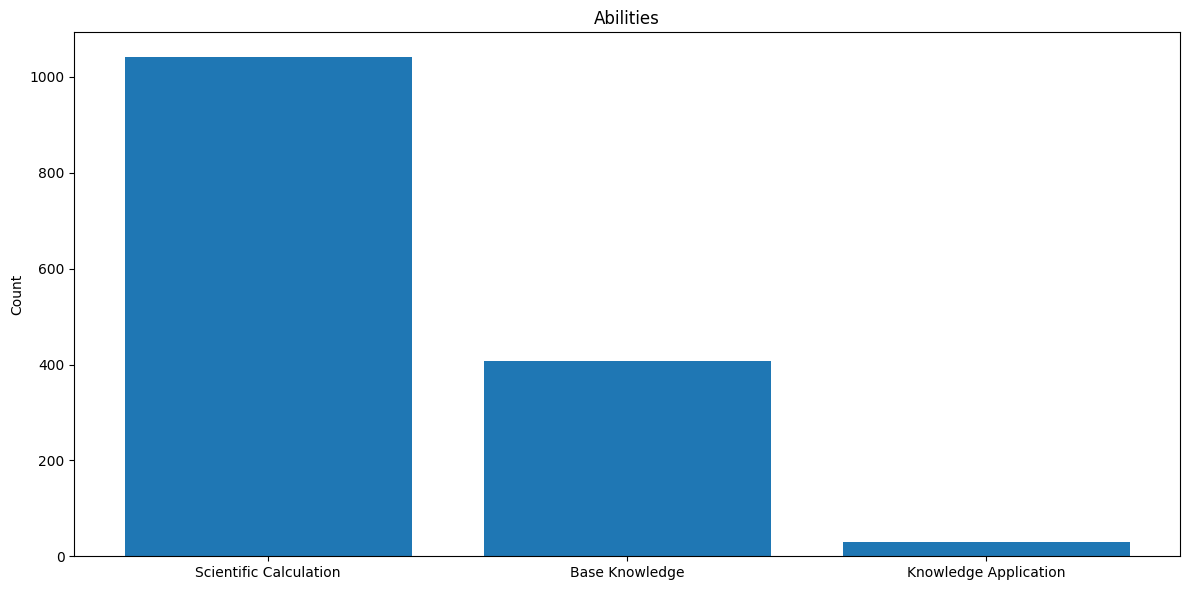

In [8]:
plt.figure(figsize=(12, 6))
plt.bar(abilities["ability"], abilities["len"])
# plt.xticks(rotation=60, ha="right")
plt.ylabel("Count")
plt.title("Abilities")
plt.tight_layout()
plt.savefig("figure.png")
plt.show()

In [9]:
df_scieval["type"].unique()

type
str
"""multiple-choice"""


In [10]:
len(df_scieval)

1478

# SCIMAT-2

In [16]:
# uncomment to download
# !git clone git@github.com:misterpawan/scimat2.git

In [89]:
subtopic_stats = dict()

In [90]:
def check_types_range(filename: str):
    with open(filename, "r") as file:
        s = file.read()

    # Pattern to match types = random.randint(<num1>,<num2>)
    pattern = r"types\s*=\s*random\.randint\(\s*(\d+)\s*,\s*(\d+)\s*\)"
    match = re.search(pattern, s)

    if match:
        num1, num2 = map(int, match.groups())
        return num2 - num1 + 1
    else:
        return 1


for topic in os.listdir("./scimat2/science"):
    subtopic_stats[topic] = dict()
    for subtopic in os.listdir(os.path.join("./scimat2/science", topic)):
        subtopic_stats[topic][subtopic] = 0
        for python_file in os.listdir(os.path.join("./scimat2/science", topic, subtopic)):
            if python_file.endswith(".py"):
                number_of_subtypes = check_types_range(os.path.join("./scimat2/science", topic, subtopic, python_file))
                subtopic_stats[topic][subtopic] += number_of_subtypes

In [91]:
topic_stats = {topic: sum([val for _, val in subtopic_stats[topic].items()]) for topic in subtopic_stats.keys()}

In [92]:
def add_space_before_upper(s: str) -> str:
    return re.sub(r"(?<!^)(?=[A-Z])", " ", s)


scimat_topics = [add_space_before_upper(topic) for topic in topic_stats.keys()]

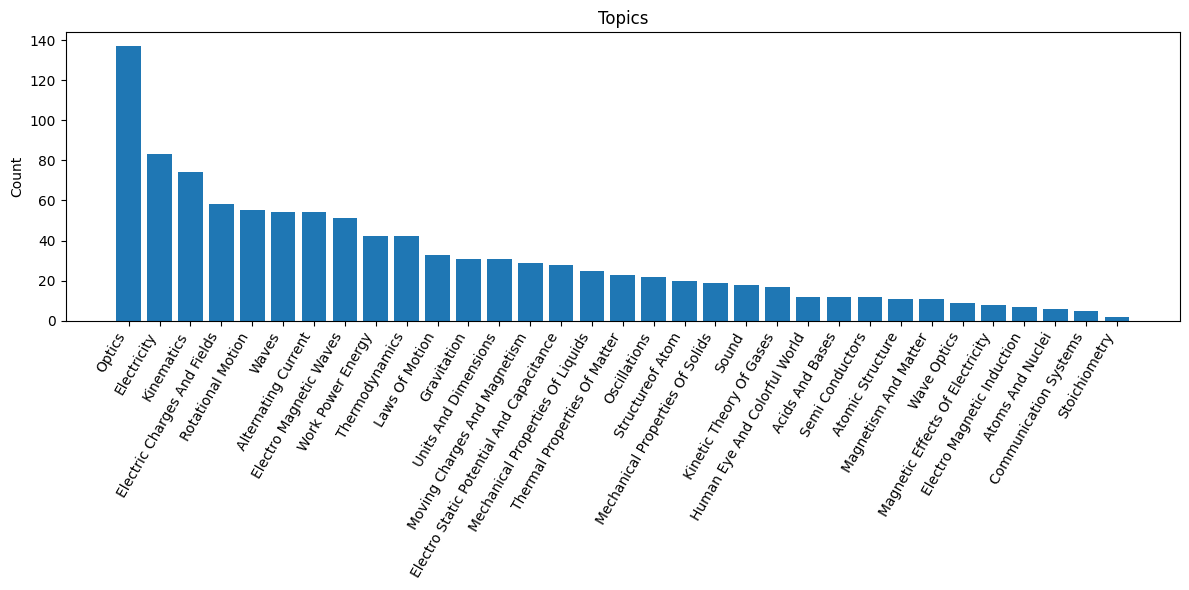

In [93]:
topics = pl.DataFrame({"topic": scimat_topics, "count": list(topic_stats.values())}).sort("count", descending=True)
plt.figure(figsize=(12, 6))
plt.bar(topics["topic"], topics["count"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Count")
plt.title("Topics")
plt.tight_layout()
plt.savefig("figure.png")
plt.show()

In [98]:
topics["topic"].head(8).to_list()

['Optics',
 'Electricity',
 'Kinematics',
 'Electric Charges And Fields',
 'Rotational Motion',
 'Waves',
 'Alternating Current',
 'Electro Magnetic Waves']

In [48]:
sum(topic_stats.values())

1041

# MMLU (college physics)

In [31]:
# uncomment to download
# dataset = datasets.load_dataset("cais/mmlu", "college_physics")
# dataset.save_to_disk("./MMLU_college_physics")

In [32]:
df_mmlu_college_physics = pl.read_ipc_stream("MMLU_college_physics/test/data-00000-of-00001.arrow")

In [34]:
len(df_mmlu_college_physics)

102

In [36]:
df_mmlu_college_physics

question,subject,choices,answer
str,str,list[str],i64
"""The quantum efficiency of a ph…","""college_physics""","[""an average of 10 times, with an rms deviation of about 4"", ""an average of 10 times, with an rms deviation of about 3"", … ""an average of 10 times, with an rms deviation of about 0.1""]",1
"""White light is normally incide…","""college_physics""","[""500 nm"", ""550 nm"", … ""650 nm""]",2
"""Which of the following is true…","""college_physics""","[""There are no changes in the internal energy of the system."", ""The temperature of the system remains constant during the process."", … ""The entropy of the system and its environment must increase.""]",2
"""The best type of laser with wh…","""college_physics""","[""a dye laser"", ""a helium-neon laser"", … ""a ruby laser""]",0
"""Excited states of the helium a…","""college_physics""","[""The Heisenberg uncertainty principle"", ""The Pauli exclusion principle"", … ""Nuclear hyperfine coupling""]",1
…,…,…,…
"""White light is normally incide…","""college_physics""","[""500 nm"", ""550 nm"", … ""650 nm""]",2
"""A nonrelativistic particle wit…","""college_physics""","[""2.5 * 10^-23 kg"", ""1.2 * 10^-22 kg"", … ""5.0 * 10^-21 kg""]",0
"""An airplane drops a payload wh…","""college_physics""","[""0"", ""40 m/s down"", … ""100 m/s north and 40 m/s down""]",1


In [47]:
def classify_questions(clf, questions, topics):
    batch_size = 16
    pred_labels = []
    pred_scores = []

    for i in range(0, len(questions), batch_size):
        texts = questions[i : i + batch_size]
        out = clf(texts, candidate_labels=topics, multi_label=False)
        if isinstance(out, dict):
            out = [out]
        pred_labels.extend([o["labels"][0] for o in out])
        pred_scores.extend([o["scores"][0] for o in out])

    return pred_labels, pred_scores


clf = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device_map="auto")

Device set to use mps


In [48]:
topics_from_scimat = scimat_topics + ["Other"]
topics_from_scieval = scieval_topics["topic"].to_list() + ["Other"]
scimat_pred_labels, scimat_pred_scores = classify_questions(
    clf=clf, questions=df_mmlu_college_physics["question"].to_list(), topics=topics_from_scimat
)
scieval_pred_labels, scieval_pred_scores = classify_questions(
    clf=clf, questions=df_mmlu_college_physics["question"].to_list(), topics=topics_from_scieval
)

In [49]:
df_mmlu_college_physics = df_mmlu_college_physics.with_columns(
    pl.Series("predicted_topic_scimat", scimat_pred_labels),
    pl.Series("predicted_confidence_scimat", scimat_pred_scores),
    pl.Series("predicted_topic_scieval", scieval_pred_labels),
    pl.Series("predicted_confidence_scieval", scieval_pred_scores),
)

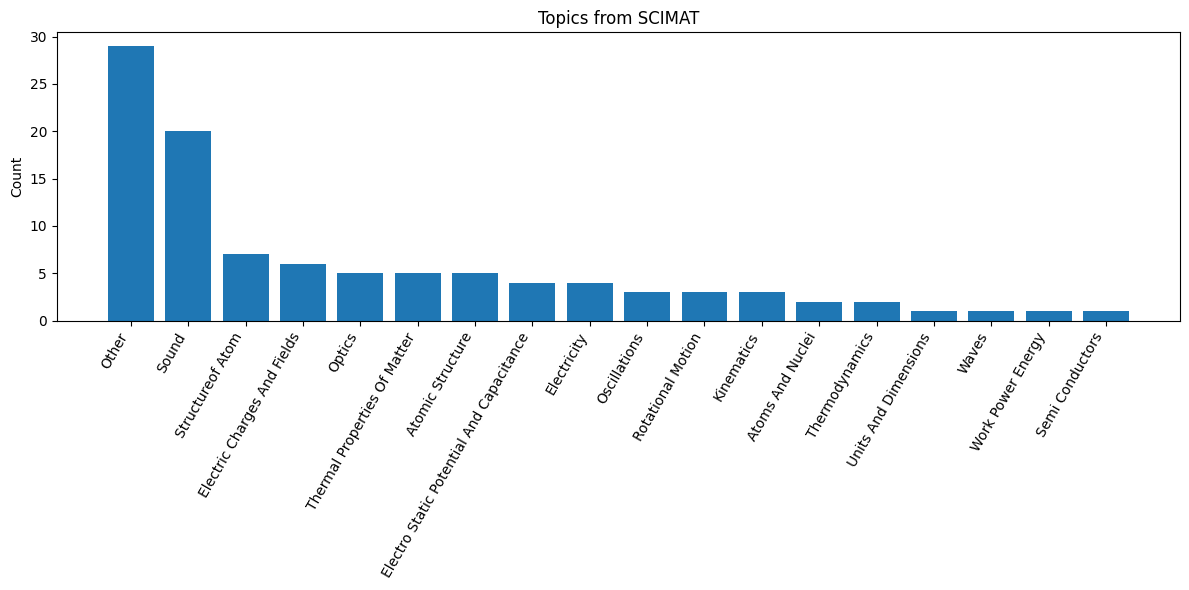

In [52]:
topics = df_mmlu_college_physics.group_by("predicted_topic_scimat").len().sort("len", descending=True)
plt.figure(figsize=(12, 6))
plt.bar(topics["predicted_topic_scimat"], topics["len"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Count")
plt.title("Topics from SCIMAT")
plt.tight_layout()
plt.savefig("figure.png")
plt.show()

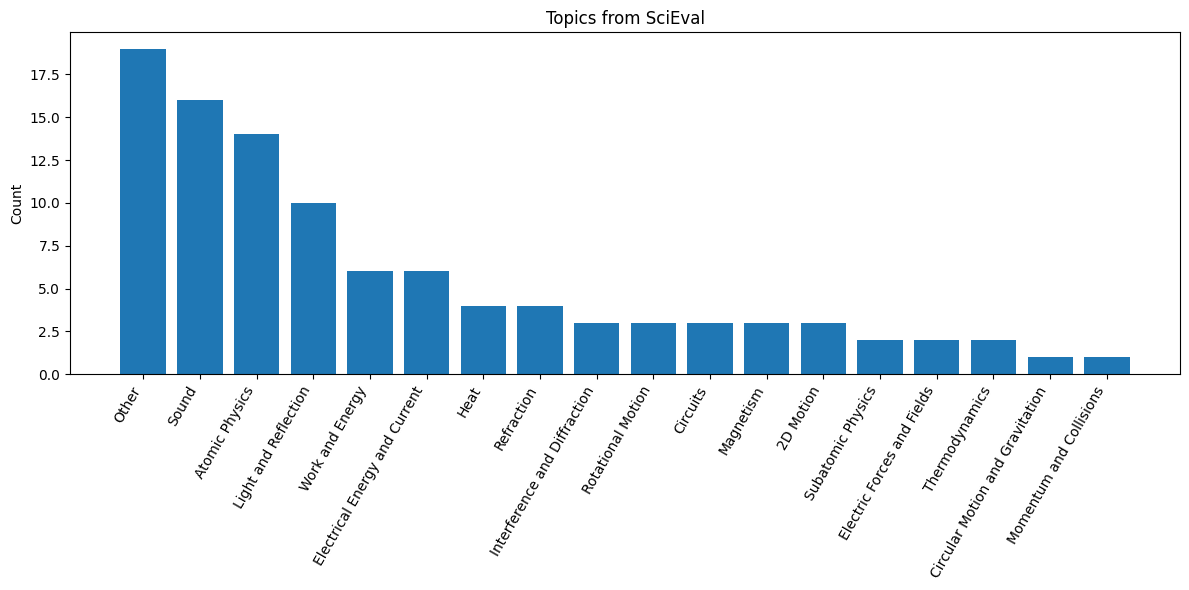

In [53]:
topics = df_mmlu_college_physics.group_by("predicted_topic_scieval").len().sort("len", descending=True)
plt.figure(figsize=(12, 6))
plt.bar(topics["predicted_topic_scieval"], topics["len"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Count")
plt.title("Topics from SciEval")
plt.tight_layout()
plt.savefig("figure.png")
plt.show()

# MMLU (conceptual physics)

In [54]:
# uncomment to download
# dataset = datasets.load_dataset("cais/mmlu", "conceptual_physics")
# dataset.save_to_disk("./MMLU_conceptual_physics")

In [55]:
df_mmlu_conceptual_physics = pl.read_ipc_stream("MMLU_conceptual_physics/test/data-00000-of-00001.arrow")

In [58]:
len(df_mmlu_conceptual_physics)

235

In [62]:
topics_from_scimat = scimat_topics + ["Other"]
topics_from_scieval = scieval_topics["topic"].to_list() + ["Other"]
scimat_pred_labels, scimat_pred_scores = classify_questions(
    clf=clf, questions=df_mmlu_conceptual_physics["question"].to_list(), topics=topics_from_scimat
)
scieval_pred_labels, scieval_pred_scores = classify_questions(
    clf=clf, questions=df_mmlu_conceptual_physics["question"].to_list(), topics=topics_from_scieval
)

In [63]:
df_mmlu_conceptual_physics = df_mmlu_conceptual_physics.with_columns(
    pl.Series("predicted_topic_scimat", scimat_pred_labels),
    pl.Series("predicted_confidence_scimat", scimat_pred_scores),
    pl.Series("predicted_topic_scieval", scieval_pred_labels),
    pl.Series("predicted_confidence_scieval", scieval_pred_scores),
)

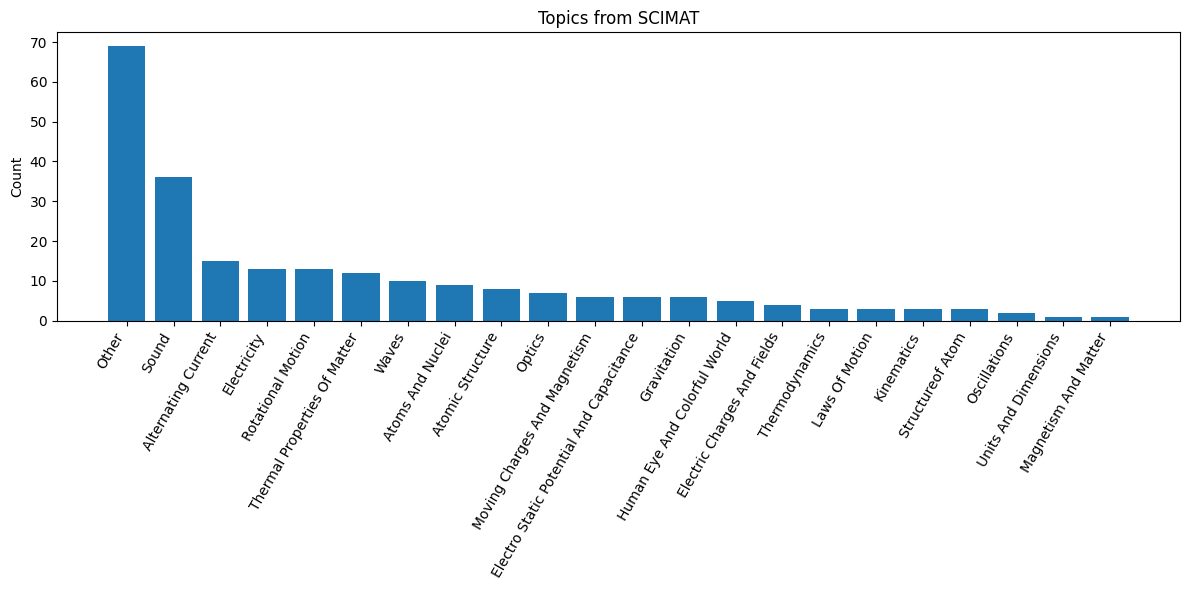

In [66]:
topics = df_mmlu_conceptual_physics.group_by("predicted_topic_scimat").len().sort("len", descending=True)
plt.figure(figsize=(12, 6))
plt.bar(topics["predicted_topic_scimat"], topics["len"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Count")
plt.title("Topics from SCIMAT")
plt.tight_layout()
plt.savefig("figure.png")
plt.show()

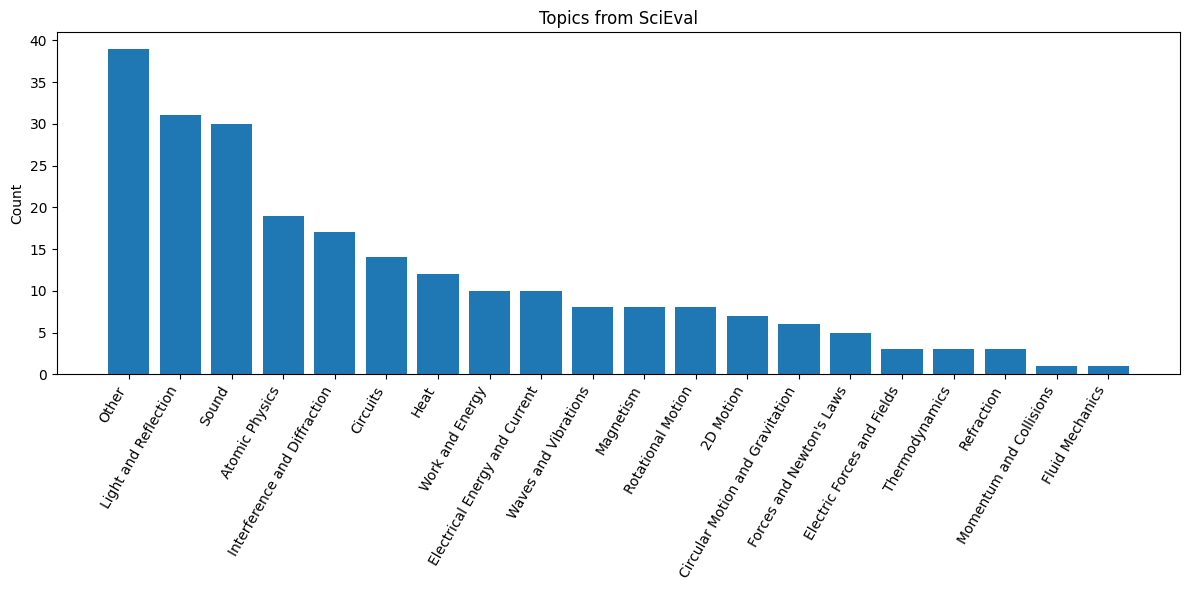

In [67]:
topics = df_mmlu_conceptual_physics.group_by("predicted_topic_scieval").len().sort("len", descending=True)
plt.figure(figsize=(12, 6))
plt.bar(topics["predicted_topic_scieval"], topics["len"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Count")
plt.title("Topics from SciEval")
plt.tight_layout()
plt.savefig("figure.png")
plt.show()

# MMLU (high school physics)

In [68]:
# uncomment to download
# dataset = datasets.load_dataset("cais/mmlu", "high_school_physics")
# dataset.save_to_disk("./MMLU_high_school_physics")

In [69]:
df_mmlu_high_school_physics = pl.read_ipc_stream("MMLU_high_school_physics/test/data-00000-of-00001.arrow")

In [72]:
len(df_mmlu_high_school_physics)

151

In [70]:
topics_from_scimat = scimat_topics + ["Other"]
topics_from_scieval = scieval_topics["topic"].to_list() + ["Other"]
scimat_pred_labels, scimat_pred_scores = classify_questions(
    clf=clf, questions=df_mmlu_high_school_physics["question"].to_list(), topics=topics_from_scimat
)
scieval_pred_labels, scieval_pred_scores = classify_questions(
    clf=clf, questions=df_mmlu_high_school_physics["question"].to_list(), topics=topics_from_scieval
)

In [71]:
df_mmlu_high_school_physics = df_mmlu_high_school_physics.with_columns(
    pl.Series("predicted_topic_scimat", scimat_pred_labels),
    pl.Series("predicted_confidence_scimat", scimat_pred_scores),
    pl.Series("predicted_topic_scieval", scieval_pred_labels),
    pl.Series("predicted_confidence_scieval", scieval_pred_scores),
)

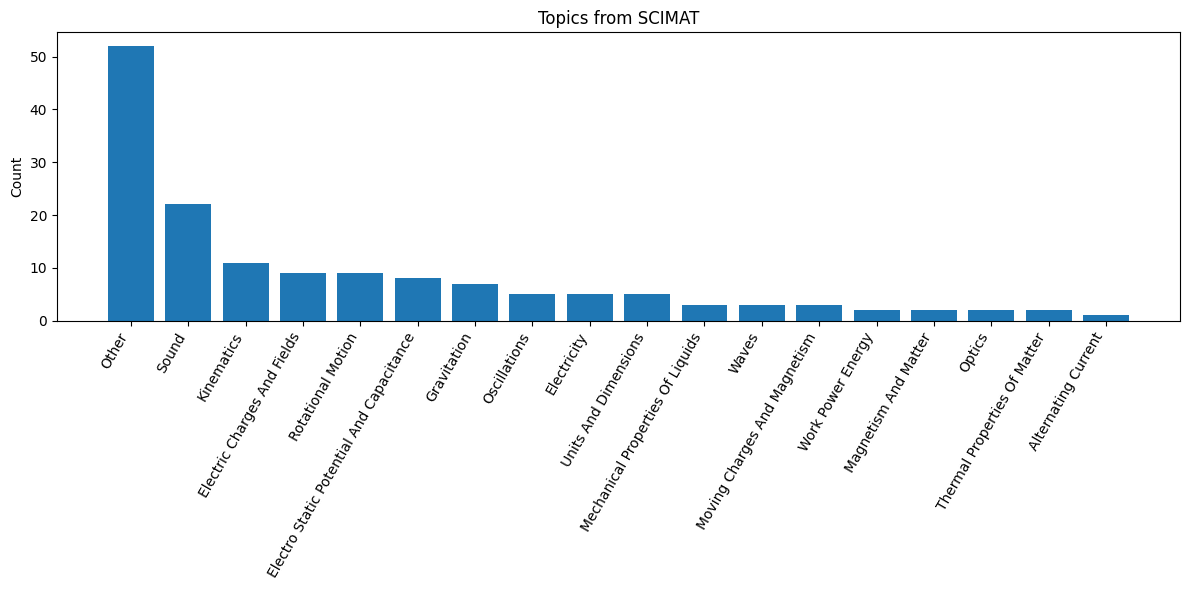

In [73]:
topics = df_mmlu_high_school_physics.group_by("predicted_topic_scimat").len().sort("len", descending=True)
plt.figure(figsize=(12, 6))
plt.bar(topics["predicted_topic_scimat"], topics["len"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Count")
plt.title("Topics from SCIMAT")
plt.tight_layout()
plt.savefig("figure.png")
plt.show()

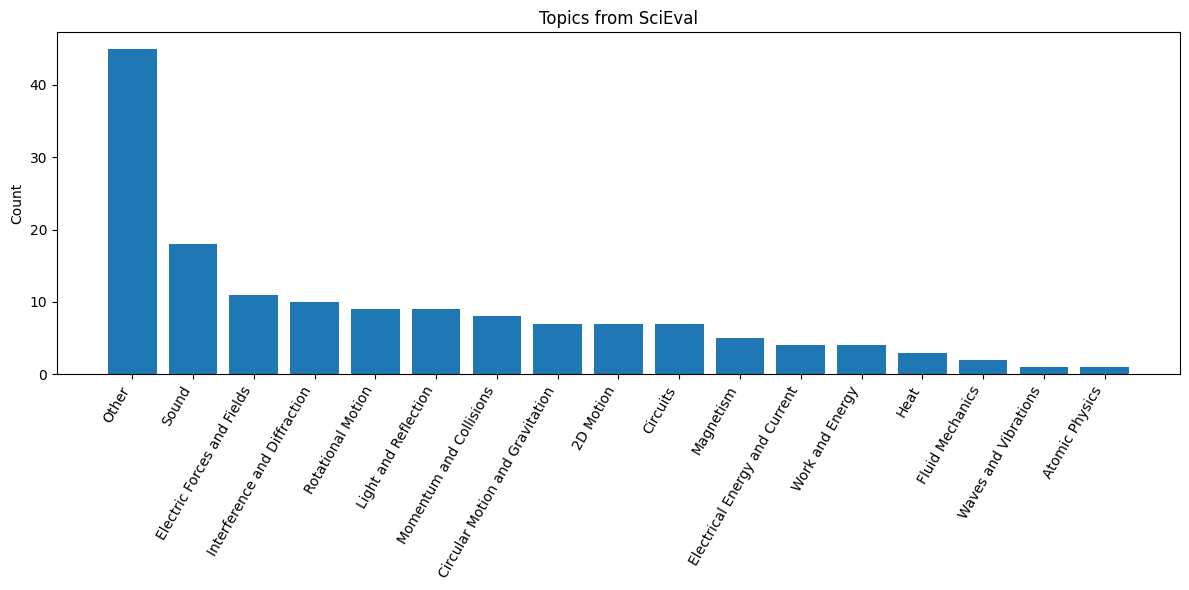

In [74]:
topics = df_mmlu_high_school_physics.group_by("predicted_topic_scieval").len().sort("len", descending=True)
plt.figure(figsize=(12, 6))
plt.bar(topics["predicted_topic_scieval"], topics["len"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Count")
plt.title("Topics from SciEval")
plt.tight_layout()
plt.savefig("figure.png")
plt.show()

In [75]:
df_mmlu_high_school_physics.filter(pl.col("predicted_topic_scieval") == "Sound")

question,subject,choices,answer,predicted_topic_scimat,predicted_confidence_scimat,predicted_topic_scieval,predicted_confidence_scieval
str,str,list[str],i64,str,f64,str,f64
"""A guitar string creates a soun…","""high_school_physics""","[""Lightly touch the guitar string in the middle such that a single node is created. Measure the length of the string; this is the wavelength."", ""Measure the length of the guitar string; this is half the wavelength."", … ""Measure the peak-to-peak distance of the wave as it passes; this is the wavelength.""]",2,"""Sound""",0.266138,"""Sound""",0.336115
"""A horizontal spring-block osci…","""high_school_physics""","[""It will increase the amplitude."", ""It will decrease the amplitude."", … ""It would depend on where the original block was in its cycle when the second block fell.""]",3,"""Oscillations""",0.539137,"""Sound""",0.098629
"""In which of the following situ…","""high_school_physics""","[""The source travels toward the stationary detector."", ""The detector travels toward the stationary source."", … ""Both the source and detector travel in opposite directions, with the source and detector moving away from each other.""]",2,"""Sound""",0.363198,"""Sound""",0.434898
"""Spring scales are used to meas…","""high_school_physics""","[""Gravitational mass"", ""Weight"", … ""Inertial mass""]",3,"""Sound""",0.100097,"""Sound""",0.141739
"""A body moving in the positive …","""high_school_physics""","[""99m"", ""36m"", … ""-99m""]",2,"""Sound""",0.084045,"""Sound""",0.103445
…,…,…,…,…,…,…,…
"""A stone is thrown horizontally…","""high_school_physics""","[""30 m/s"", ""40 m/s"", … ""60 m/s""]",2,"""Kinematics""",0.074469,"""Sound""",0.089826
"""A string of fixed tension and …","""high_school_physics""","[""The string length is not a multiple of half the wavelength of the wave."", ""The wave speed on the string is fixed."", … ""The wavelength of the wave produced by the speaker is equal to the speed of waves on the string divided by 60 Hz.""]",0,"""Sound""",0.17585,"""Sound""",0.19429
"""An alarm whose frequency is 40…","""high_school_physics""","[""appears higher than 400 Hz and the frequency increase as it falls"", ""appears higher than 400 Hz and the frequency decreases as it falls"", … ""appears lower than 400 Hz and the frequency increases as it falls""]",2,"""Oscillations""",0.302838,"""Sound""",0.14219
